In [61]:
%reload_ext autoreload
%autoreload 2

import os, sys, numpy as np, pandas as pd, tensorflow as tf, cv2
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Activation

from matplotlib import pyplot as plt
from src import utils


# plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid') # 

%matplotlib inline

In [61]:
raw = pd.read_csv('./data/raw_tr_financial_churn.csv')
raw.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,6396,15707918,Bentley,741,Germany,Female,36,0,127675.39,2,1,0,74260.16,0
1,6055,15773013,Uvarov,633,France,Female,47,0,0.00,1,1,1,6342.84,1
2,8866,15639004,Chiemezie,668,France,Male,72,2,0.00,2,1,1,70783.61,0
3,9098,15606901,Graham,728,France,Male,43,7,0.00,2,1,0,40023.70,0
4,3865,15808960,Alleyne,620,Germany,Male,40,5,108197.11,2,1,0,49722.34,0


In [17]:
data = raw[['CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited']].copy()

In [18]:
data.Exited.value_counts()

0    5952
1    1548
Name: Exited, dtype: int64

In [19]:
data['Gender'] = data['Gender'].map(lambda e: 0 if e =='Female' else 1)

In [20]:
pd.get_dummies(data['Geography']).head()

,France,Germany,Spain
0,0,1,0
1,1,0,0
2,1,0,0
3,1,0,0
4,0,1,0


In [21]:
data = pd.concat([data, pd.get_dummies(data['Geography'])], axis=1)
del data['Geography']
data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Germany,Spain
0,741,0,36,0,127675.39,2,1,0,74260.16,0,0,1,0
1,633,0,47,0,0.00,1,1,1,6342.84,1,1,0,0
2,668,1,72,2,0.00,2,1,1,70783.61,0,1,0,0
3,728,1,43,7,0.00,2,1,0,40023.70,0,1,0,0
4,620,1,40,5,108197.11,2,1,0,49722.34,0,0,1,0


##  Base Feature Engineering
- one hot encoding
- standardization, normalization

In [2]:
raw = pd.read_csv('./data/raw_tr_financial_churn.csv')
raw_vl = pd.read_csv('./data/raw_vl_financial_churn.csv')
raw.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,6396,15707918,Bentley,741,Germany,Female,36,0,127675.39,2,1,0,74260.16,0
1,6055,15773013,Uvarov,633,France,Female,47,0,0.00,1,1,1,6342.84,1
2,8866,15639004,Chiemezie,668,France,Male,72,2,0.00,2,1,1,70783.61,0
3,9098,15606901,Graham,728,France,Male,43,7,0.00,2,1,0,40023.70,0
4,3865,15808960,Alleyne,620,Germany,Male,40,5,108197.11,2,1,0,49722.34,0


In [16]:
def basic_feature_engineer(raw, is_train=True, scaler=None):
    data = raw[['CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited']].copy()
    data['Gender'] = data['Gender'].map(lambda e: 0 if e =='Female' else 1)
    data = pd.concat([data, pd.get_dummies(data['Geography'])], axis=1)
    del data['Geography']
    
    # Split features, label
    data_x, y = data.drop('Exited', 1), data.pop('Exited')
    columns = data_x.columns
    if is_train:
        # scaler = MinMaxScaler()
        scaler = StandardScaler()
        data_x = pd.DataFrame(data=scaler.fit_transform(data_x), columns=columns)
    else:
        data_x = pd.DataFrame(data=scaler.transform(data_x), columns=columns)
    return data_x, y, scaler

# Trnasform raw data to foramt model recognized
tr_x, tr_y, scaler = basic_feature_engineer(raw, is_train=True)
vl_x, vl_y, _ = basic_feature_engineer(raw_vl, is_train=False, scaler=scaler)

In [20]:
print(tr_x.shape, tr_y.shape)
tr_x.head()

(7500, 12) (7500,)


,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,France,Germany,Spain
0,0.931808,-1.096651,-0.286140,-1.726890,0.818951,0.804202,0.648425,-1.032253,-0.449945,-1.001601,1.716790,-0.570986
1,-0.185926,-1.096651,0.761549,-1.726890,-1.223103,-0.913689,0.648425,0.968755,-1.631281,0.998401,-0.582482,-0.570986
2,0.176303,0.911867,3.142658,-1.036539,-1.223103,0.804202,0.648425,0.968755,-0.510415,0.998401,-0.582482,-0.570986
3,0.797266,0.911867,0.380571,0.689338,-1.223103,0.804202,0.648425,-1.032253,-1.045445,0.998401,-0.582482,-0.570986
4,-0.320468,0.911867,0.094838,-0.001013,0.507413,0.804202,0.648425,-1.032253,-0.876750,-1.001601,1.716790,-0.570986


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6)                 78        
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 127
Trainable params: 127
Non-trainable params: 0
_________________________________________________________________
Train on 7500 samples, validate on 2500 samples
Epoch 1/30
7500/7500 [==============================] - 1s 89us/step - loss: 0.6865 - acc: 0.7881 - val_loss: 0.6771 - val_acc: 0.8044
Epoch 2/30
7500/7500 [==============================] - 0s 18us/step - loss: 0.6646 - acc: 0.7936 - val_loss: 0.6435 - val_acc: 0.8044
Epoch 3/30
7500/7500 [==============================] - 0s 20us/step - loss: 0.6162 - acc:

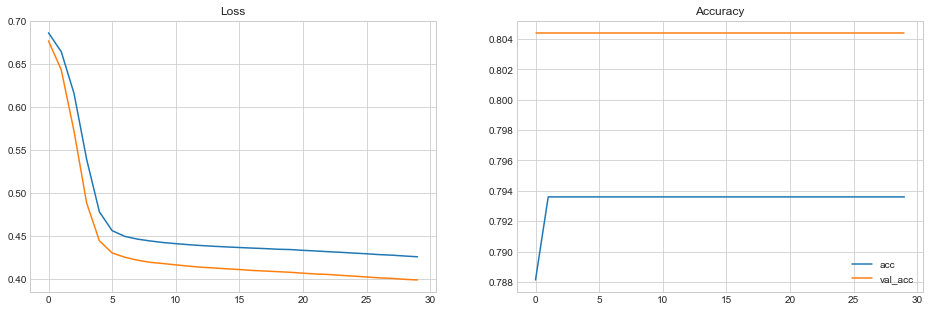

In [35]:
K.clear_session()

model = Sequential()
model.add(Dense(units = 6, kernel_initializer='uniform', activation = 'relu', input_dim = 12))
model.add(Dense(units = 6, kernel_initializer='uniform', activation = 'relu'))
model.add(Dense(units = 1, kernel_initializer='uniform', activation = 'sigmoid'))
model.summary()
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
hist = model.fit(tr_x, tr_y, validation_data=(vl_x, vl_y), batch_size=200, epochs=30)
utils.plot_result(hist)

<br/>
<br/>
<br/>

## Advanced Feature Engineering

In [37]:
raw = pd.read_csv('./data/raw_tr_financial_churn.csv')
raw_vl = pd.read_csv('./data/raw_vl_financial_churn.csv')
raw.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,6396,15707918,Bentley,741,Germany,Female,36,0,127675.39,2,1,0,74260.16,0
1,6055,15773013,Uvarov,633,France,Female,47,0,0.00,1,1,1,6342.84,1
2,8866,15639004,Chiemezie,668,France,Male,72,2,0.00,2,1,1,70783.61,0
3,9098,15606901,Graham,728,France,Male,43,7,0.00,2,1,0,40023.70,0
4,3865,15808960,Alleyne,620,Germany,Male,40,5,108197.11,2,1,0,49722.34,0


In [54]:
def feature_engineer_sqare_sqrt(raw, is_train=True, scaler=None):
    data = raw[['CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited']].copy()
    data['Gender'] = data['Gender'].map(lambda e: 0 if e =='Female' else 1)
    data = pd.concat([data, pd.get_dummies(data['Geography'])], axis=1)
    del data['Geography']
    
    # Split features, label
    data_x, y = data.drop('Exited', 1), data.pop('Exited')
    columns = data_x.columns
    if is_train:
        scaler = StandardScaler()
        # scaler = MinMaxScaler()
        data_x = pd.DataFrame(data=scaler.fit_transform(data_x), columns=columns)
    else:
        data_x = pd.DataFrame(data=scaler.transform(data_x), columns=columns)

    # 加入二次項
    for num_col in ('CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary'):
        data_x[f'Square{num_col}'] = data_x[num_col] ** 2
        # data_x[f'Sqrt{num_col}'] = np.sqrt(data_x[num_col])
        data_x[f'Sqrt{num_col}'] = data_x[num_col].map(lambda e: np.sqrt(e) if e >= 0 else 0)
        
    return data_x, y, scaler
    # return data

tr_x, tr_y, sc = feature_engineer_sqare_sqrt(raw, is_train=True)
vl_x, vl_y, _ = feature_engineer_sqare_sqrt(raw_vl, is_train=False, scaler=scaler)

In [55]:
tr_x.filter(axis='columns', regex='^Sqrt').head()

,SqrtCreditScore,SqrtAge,SqrtTenure,SqrtBalance,SqrtNumOfProducts,SqrtEstimatedSalary
0,0.965302,0.000000,0.000000,0.904959,0.896773,0.0
1,0.000000,0.872668,0.000000,0.000000,0.000000,0.0
2,0.419884,1.772754,0.000000,0.000000,0.896773,0.0
3,0.892897,0.616904,0.830264,0.000000,0.896773,0.0
4,0.000000,0.307958,0.000000,0.712329,0.896773,0.0


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                800       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 1,473
Trainable params: 1,473
Non-trainable params: 0
_________________________________________________________________
Train on 7500 samples, validate on 2500 samples
Epoch 1/30
7500/7500 [==============================] - 1s 99us/step - loss: 0.7267 - acc: 0.4028 - val_loss: 0.6540 - val_acc: 0.7720
Epoch 2/30
7500/7500 [==============================] - 0s 22us/step - loss: 0.5867 - acc

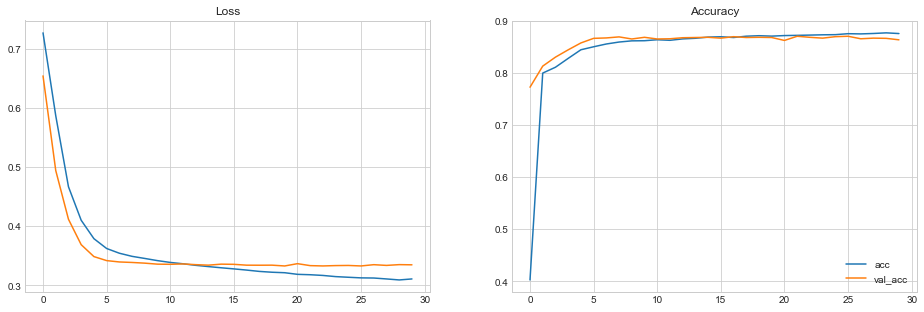

In [57]:
K.clear_session()

model = Sequential()
model.add(Dense(units = 32, kernel_initializer='glorot_uniform', activation = 'relu', input_dim = 24))
model.add(Dense(units = 16, kernel_initializer='glorot_uniform', activation = 'relu'))
model.add(Dense(units = 8, kernel_initializer='glorot_uniform', activation = 'relu'))
model.add(Dense(units = 1, kernel_initializer='glorot_uniform', activation = 'sigmoid'))
model.summary()
adam = keras.optimizers.Adam(0.001)
model.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = ['accuracy'])
hist = model.fit(tr_x, tr_y, validation_data=(vl_x, vl_y), batch_size=200, epochs=30)
utils.plot_result(hist)

## 嘗試Train更多次, 是否效果會更好

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                800       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 1,473
Trainable params: 1,473
Non-trainable params: 0
_________________________________________________________________
Train on 7500 samples, validate on 2500 samples
Epoch 1/100
7500/7500 [==============================] - 1s 68us/step - loss: 0.4588 - acc: 0.8023 - val_loss: 0.3667 - val_acc: 0.8440
Epoch 2/100
7500/7500 [==============================] - 0s 22us/step - loss: 0.3635 - a

7500/7500 [==============================] - 0s 19us/step - loss: 0.2434 - acc: 0.9021 - val_loss: 0.4043 - val_acc: 0.8460
Epoch 55/100
7500/7500 [==============================] - 0s 18us/step - loss: 0.2389 - acc: 0.9057 - val_loss: 0.4156 - val_acc: 0.8412
Epoch 56/100
7500/7500 [==============================] - 0s 17us/step - loss: 0.2441 - acc: 0.9027 - val_loss: 0.4007 - val_acc: 0.8468
Epoch 57/100
7500/7500 [==============================] - 0s 19us/step - loss: 0.2400 - acc: 0.9031 - val_loss: 0.4163 - val_acc: 0.8460
Epoch 58/100
7500/7500 [==============================] - 0s 18us/step - loss: 0.2381 - acc: 0.9020 - val_loss: 0.4075 - val_acc: 0.8484
Epoch 59/100
7500/7500 [==============================] - 0s 17us/step - loss: 0.2353 - acc: 0.9048 - val_loss: 0.4186 - val_acc: 0.8408
Epoch 60/100
7500/7500 [==============================] - 0s 18us/step - loss: 0.2375 - acc: 0.9061 - val_loss: 0.4158 - val_acc: 0.8440
Epoch 61/100
7500/7500 [==============================

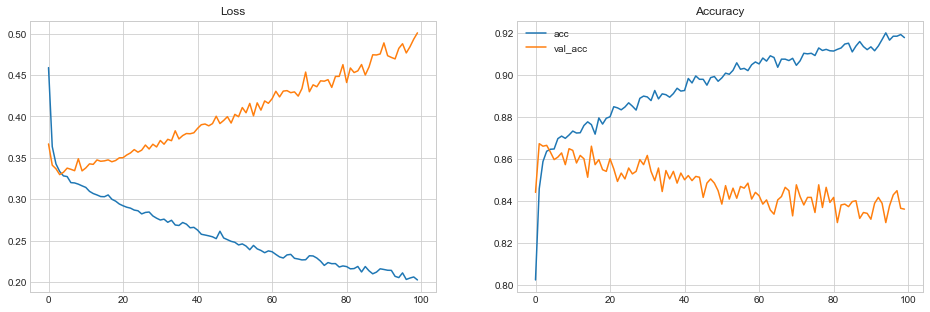

In [60]:
K.clear_session()

model = Sequential()
model.add(Dense(units = 32, kernel_initializer='glorot_uniform', activation = 'relu', input_dim = 24))
model.add(Dense(units = 16, kernel_initializer='glorot_uniform', activation = 'relu'))
model.add(Dense(units = 8, kernel_initializer='glorot_uniform', activation = 'relu'))
model.add(Dense(units = 1, kernel_initializer='glorot_uniform', activation = 'sigmoid'))
model.summary()
adam = keras.optimizers.Adam(0.005)
model.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = ['accuracy'])
hist = model.fit(tr_x, tr_y, validation_data=(vl_x, vl_y), batch_size=200, epochs=100)
utils.plot_result(hist)

## 加入Dropout

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                800       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_3 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total para

7500/7500 [==============================] - 0s 21us/step - loss: 0.3594 - acc: 0.8435 - val_loss: 0.3432 - val_acc: 0.8580
Epoch 52/100
7500/7500 [==============================] - 0s 22us/step - loss: 0.3550 - acc: 0.8399 - val_loss: 0.3435 - val_acc: 0.8564
Epoch 53/100
7500/7500 [==============================] - 0s 21us/step - loss: 0.3571 - acc: 0.8396 - val_loss: 0.3428 - val_acc: 0.8628
Epoch 54/100
7500/7500 [==============================] - 0s 22us/step - loss: 0.3622 - acc: 0.8400 - val_loss: 0.3437 - val_acc: 0.8576
Epoch 55/100
7500/7500 [==============================] - 0s 24us/step - loss: 0.3603 - acc: 0.8419 - val_loss: 0.3426 - val_acc: 0.8604
Epoch 56/100
7500/7500 [==============================] - 0s 21us/step - loss: 0.3627 - acc: 0.8408 - val_loss: 0.3420 - val_acc: 0.8592
Epoch 57/100
7500/7500 [==============================] - 0s 21us/step - loss: 0.3550 - acc: 0.8412 - val_loss: 0.3409 - val_acc: 0.8632
Epoch 58/100
7500/7500 [==============================

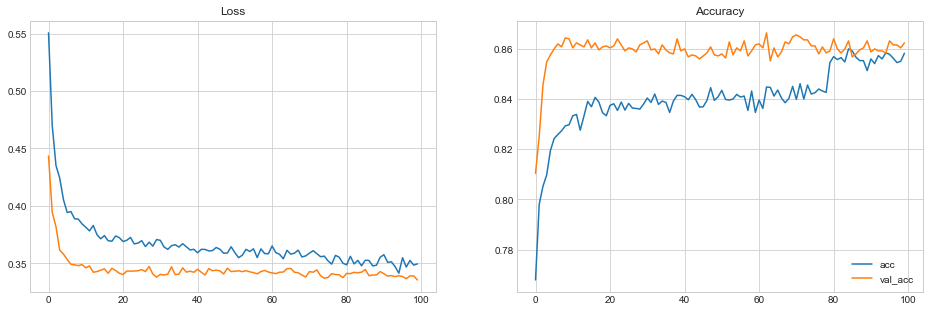

In [66]:
from keras.layers import Dropout

K.clear_session()

model = Sequential()
model.add(Dense(units = 32, kernel_initializer = 'glorot_uniform', activation = 'relu', input_dim = 24))
model.add(Dropout(.5))
model.add(Dense(units = 16, kernel_initializer = 'glorot_uniform', activation = 'relu'))
model.add(Dropout(.3))
model.add(Dense(units = 8, kernel_initializer = 'glorot_uniform', activation = 'relu'))
model.add(Dropout(.3))
model.add(Dense(units = 1, kernel_initializer = 'glorot_uniform', activation = 'sigmoid'))
model.summary()
adam = keras.optimizers.Adam(0.005)
model.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = ['accuracy'])
hist = model.fit(tr_x, tr_y, validation_data=(vl_x, vl_y), batch_size=200, epochs=100)
utils.plot_result(hist)

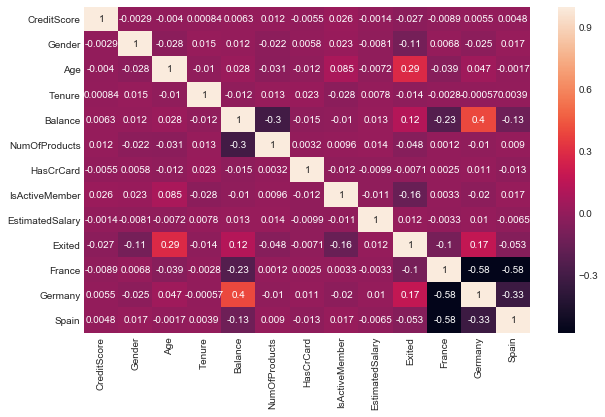

In [62]:
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True)
plt.show()